In [1]:
#ideas for importing data:
#1. get data in batches: export to a list, export list to a csv, import csv for each new run - do data preprocessing
#2. get data in batches, process each batch, export to a csv, import csv with specified datatypes
#3. how big is a "big" dataset? whats the general limit for what i can export to work with on my computer?
#4. multithreading vs. multiprocessing?
#5. export data to a database? SQLalchemy
#6. work directly in colab, then download and export to github?

#call with ori:
#options:
#1. download locally, wait for however long it takes, large = when it stops fitting in ram
#mem = temp working space, fast to access but can't store much, might be erased; disk = long term storage
#goal = get something done quickly
#embarrassingly parallel problems: processes don't need to talk to each other 

#2. BQ: data stays in google servers, might have to pay eventually, if you need to do a lot of processing / really large datasets
#take the processed results 
#use api to query from BQ

#3. spark cluster on AWS

#keep raw data - quickly recover

#python stores each num as an obj; each obj has overhead involved (methods, value, ref count)
#numpy stores all of these values as one obj

## To Do:
- multiprocessing or multithreading to get more data
- save data to csv, use pandas to read in and indicate appropriate data types
- data processing: add time, drop nulls
- reduce memory
- create cleaner categories; create function to indicate any new categories that need to be coded


## Import dataset, reduce memory

In [2]:
import pandas as pd
import numpy as np
import requests
from sodapy import Socrata
import os
import seaborn as sns
from matplotlib import pyplot as plt
import sys
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
import pygsheets
from bokeh.plotting import figure, output_file, output_notebook, show, save, reset_output
from datetime import datetime, date, time 

os.getcwd()
pd.options.display.max_columns=50

/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
#define parameters for endpoint, dataset, and app token
data_url = 'data.cityofnewyork.us'
dataset = 'erm2-nwe9'
app_token = 'dM7DDeidbAmgtydtJVV1epbiU'

#sets up the connection, need application token to override throttling limits
#username and password only required for creating or modifying data
client = Socrata(data_url, app_token)
client.timeout = 6000

#count number of records in desired dataset
record_count = client.get(dataset, select='count(*)', where="created_date >='2019-11-01'")
record_count

[{'count': '990318'}]

In [127]:
def get_data(chunk_size=500000, total_rows=1000000):
    start = 0
    results=[]

    #paginate through dataset in sets of 10000 to get all records since 2019
    while True:
        print(f'{start} rows retrieved')
        results.extend(client.get(dataset,where="created_date >= '2019-11-01'", 
                                  limit=chunk_size, offset=start))
        start += chunk_size
        if start > total_rows:
            break
    return results

orig_results = get_data()
orig_df = pd.DataFrame(orig_results)
orig_df.to_csv('/Users/christinejiang/Documents/Python/data/311_data.csv', index=False)

0 rows retrieved
100000 rows retrieved
200000 rows retrieved
300000 rows retrieved
400000 rows retrieved
500000 rows retrieved
600000 rows retrieved
700000 rows retrieved
800000 rows retrieved
900000 rows retrieved
1000000 rows retrieved


In [4]:
def reduce_memory(df):
    """improved version of memory reduction function. uses pd.to_numeric to downcast types;
    also considers whether there are few enough unique values to warrant use of category vs. object."""
    orig_size = df.memory_usage().sum()/1024**2
    dtypes = df.dtypes.astype(str).unique()
    converted_float = pd.DataFrame()
    converted_int = pd.DataFrame()
    converted_obj = pd.DataFrame()
    converted_misc = pd.DataFrame()

    #convert floats
    selected_float = df.select_dtypes(include='float')
    converted_float = selected_float.apply(pd.to_numeric, downcast='float')
    float_size = selected_float.memory_usage().sum()/1024**2
    converted_float_size = converted_float.memory_usage().sum()/1024**2
    print(f'floats: {float_size:.2f} reduced to {converted_float_size:.2f} MB')

    #convert ints
    selected_int = df.select_dtypes(include='integer')
    converted_int = selected_int.apply(pd.to_numeric, downcast='integer')
    int_size = selected_int.memory_usage().sum()/1024**2
    converted_int_size = converted_int.memory_usage().sum()/1024**2
    print(f'ints: {int_size:.2f} reduced to {converted_int_size:.2f} MB')
    
    #convert objects / categories
    selected_object = df.select_dtypes(include=['object', 'category'])
    obj_size = selected_object.memory_usage().sum()/1024**2
    for col in selected_object.columns:
        count = len(selected_object[col])
        unique = len(selected_object[col].astype(str).unique())
        if unique < count/2:
            converted_obj[col] = selected_object[col].astype(str).astype('category')
        else:
            converted_obj[col] = selected_object[col].astype(str)
    converted_obj_size = converted_obj.memory_usage().sum()/1024**2
    print(f'object: {obj_size:.2f} reduced to {converted_obj_size:.2f} MB')

    #join floats, ints, and objects / categories
    float_int = converted_float.join(converted_int)
    float_int_obj = float_int.join(converted_obj)
    
    #for any columns of any other type, keep them the same and join to the converted dataframe
    no_change_cols = [x for x in df.columns if x not in float_int_obj.columns]
    reduced_df = float_int_obj.join(df[no_change_cols])
    
    #re-order columns to appear in original order
    reduced_df = reduced_df[df.columns]
    reduced_size = reduced_df.memory_usage().sum()/1024**2
    print(f'final df: {orig_size:.2f} reduced to {reduced_size:.2f} MB, {(orig_size-reduced_size)/orig_size*100:.1f}% reduction')
    return reduced_df

In [5]:
#olddf - most dtypes are objects, some are ints and some are floats
#BUT olddf datatypes get changed inplace after running reduce_mem_usage! becomes mostly categorical
olddf = pd.read_csv('/Users/christinejiang/Documents/Python/data/311_data.csv')

#newdf - most dtypes are categorical, some ints and floats
newdf = reduce_memory(olddf)

/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (32,34,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


floats: 45.02 reduced to 22.51 MB
ints: 7.50 reduced to 3.75 MB
object: 255.13 reduced to 98.18 MB
final df: 307.66 reduced to 124.45 MB, 59.5% reduction


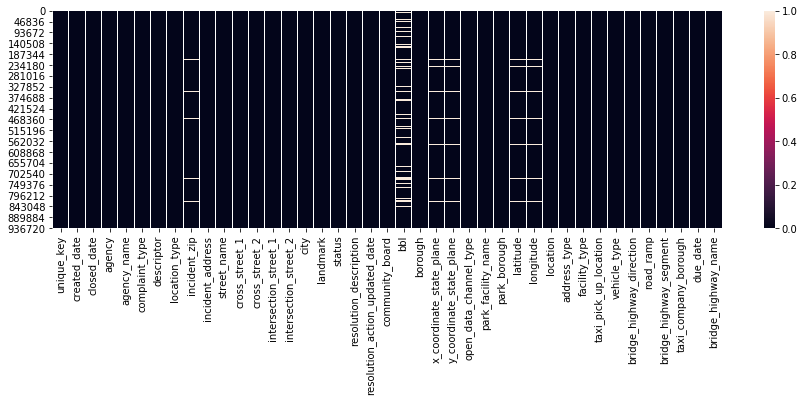

In [6]:
#need to fix this - categorical blanks are not showing up as blanks
plt.rc('figure',figsize=(15,4))
#display(sns.heatmap(olddf.isnull()))
display(sns.heatmap(newdf.isnull()))

## Data Processing
- need to create a function that will show the new, unmapped categories for each new imported dataset
- need to indicate column types upon reading in with pandas, use the reduce memory function after preprocessing

In [7]:
def preprocess_df(df):
    '''drop columns that are mostly blank, create time-related columns from date columns'''
    #drop mostly blank columns
    cleandf = df.drop(['intersection_street_1',
               'intersection_street_2',
               'taxi_company_borough',
               'taxi_pick_up_location',
               'bridge_highway_name',
               'bridge_highway_direction',
               'road_ramp',
               'bridge_highway_segment',
               'landmark',
               'vehicle_type'], axis=1, inplace=False)

    #convert date related columns to datetime
    for col in cleandf.columns:
        if 'date' in col:
            cleandf[col] = pd.to_datetime(cleandf[col])
            
    #created time-related columns from date columns
    cleandf['created_mdy'] = [x.strftime('%Y-%m-%d') for x in cleandf['created_date']]
    cleandf['created_year'] = [x.year for x in cleandf['created_date']]
    cleandf['created_month'] = [x.strftime('%b') for x in cleandf['created_date']]
    cleandf['created_day'] = [x.day for x in cleandf['created_date']]
    cleandf['created_weekday'] = [x.strftime('%a') for x in processed_df['created_date']]
    cleandf['created_week'] = [x.week for x in cleandf['created_date']]
    cleandf['created_hour'] = [x.hour for x in cleandf['created_date']]
    cleandf['closed_hour'] = [x.hour for x in cleandf['closed_date']]
    cleandf['time_to_close'] = cleandf['closed_date'] - cleandf['created_date']
    return cleandf

In [8]:
def export_col_values(workbook, df, columns):
    """for a list of columns, creates a new sheet for each column and exports unique values and their counts to that sheet"""
    for col in columns:
        value_counts = df[col].value_counts()
        counts_df = pd.DataFrame(value_counts).reset_index()
        try:
            worksheet = workbook.worksheet_by_title(col)
        except WorksheetNotFound:
            workbook.add_worksheet(col)
            worksheet = workbook.worksheet_by_title(col)
        worksheet.set_dataframe(counts_df, start='A1')
    print(f'{len(columns)} sets of column values exported.')
        
def get_valid_names(workbook, columns, start='D1'):
    """extracts the valid names manually entered by the user in column D of the workbook"""
    valid_names = {}
    for col in columns:
        worksheet = workbook.worksheet_by_title(col)
        valid_matrix = worksheet.get_values(start='D1', end='D100')
        valid_names[col] = [v[0] for v in valid_matrix]
    return valid_names

def fuzzy_match(value):
    """returns the best match for each column; fuzzy match score of < 90 will return 'Other'"""
    match = process.extract(query=value, choices=valid_names[col], limit=1)
    if match[0][1] < 90:
        return 'Other'
    else:
        return match[0][0]

In [9]:
#use pygsheets to connect to workbook where we will export unique column values
client = pygsheets.authorize(service_account_file='/Users/christinejiang/Documents/Python/data/client_secret.json')
workbook = client.open('311_data_cleaning')
columns = ['agency_name','complaint_type','descriptor','location_type','city']

#export unique column values and their counts
export_col_values(workbook, newdf, columns)

5 sets of column values exported.


In [10]:
#COMMENT OUT THIS CELL IF DOING CATEGORY REVIEW
#get dictionary of lists with valid names for each column
valid_names = get_valid_names(workbook, columns, start='D1')

#fuzzy match each of the columns to the available values
for col in columns:
    newdf['cleaned_'+col] = newdf[col].apply(fuzzy_match)

In [11]:
#preprocess dataset to remove mostly null columns and create date columns
processed_df = preprocess_df(newdf)
clean_processed = reduce_memory(processed_df)

NameError: name 'processed_df' is not defined

## Bokeh Visualizations

In [ ]:
reset_output()

In [ ]:
from bokeh.plotting import figure, output_file, show, output_notebook

x = [1,2,3,4,5]
y = [6,7,2,4,5]

output_notebook()
p = figure(title='simple line example',x_axis_label='x',y_axis_label='y')
p.line(x,y, legend='temp.', line_width=2)
show(p)

In [ ]:
x = [1,2,3,4,5]
y0 = [i**2 for i in x]
y1 = [10**i for i in x]
y2 = [10**(i**2) for i in x]

#output to static html file
#output_file('log_lines.html')
output_notebook()

#create new plot
p = figure(
    tools = 'pan, box_zoom, reset, save',
    y_axis_type = 'log', y_range=[0.001, 10**11], title='log axis example',
    x_axis_label='sections', y_axis_label = 'particles'
)

#add some renderers
p.line(x, x, legend='y=x')
p.circle(x, x, legend='y=x', fill_color='white', size=8)
p.line(x, y0, legend='y=x^2', color = 'red', line_width=3)
p.line(x, y1, legend='y=10^x', line_color='orange')
p.circle(x, y1, legend='y=10^x', fill_color='green', line_color='yellow', size=6)
p.line(x, y2, legend='y=10^x^2', line_color='orange', line_dash = '4')
show(p)

In [ ]:
grouped = clean_processed.groupby(['cleaned_city','cleaned_descriptor'])['count'].sum()
grouped_index = grouped.reset_index()
grouped_index.sort_values('count',inplace=True, ascending=False)
sns.barplot(x='cleaned_city',y='count',hue='cleaned_descriptor',data=grouped_index)

In [ ]:
grouped_index.sort_values('count',ascending=False, inplace=True)
grouped_index

In [ ]:
sns.barplot(x=final_date['', y=final_date['unique_key'], hue=final_date['cleaned_descriptor'])
axes = plt.gca()

In [ ]:
clean_processed['count'] = 1
pivot = clean_processed.pivot_table(values='count',index='cleaned_descriptor',columns=['created_month'],aggfunc='sum')
pivot= pivot[['Nov','Dec','Jan','Feb','Mar','Apr','May']]
pivot.drop('Other', inplace=True)
pivot.sort_values('Nov',ascending=False, inplace=True)

In [ ]:
plt.rc('figure',figsize=(15,15))
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='mako_r', square=True)

In [ ]:
clean_processed.head()